In [1]:
import numpy as np
import torchvision as thv
import matplotlib.pyplot as plt

#### (a)

In [2]:
def shuffle_dataset(X, Y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    return X[indices], Y[indices]

def subsample(dataset, num_samples, num_classes):
    X = dataset.data.numpy()

    # flatten X and change type
    X = X.reshape(X.shape[0], -1).astype(np.float32)

    Y = np.array(dataset.targets)

    # final size of each class
    class_size = int(num_samples / 10)
    indices = []

    for label in range(num_classes):
        # find indices for the given label and select the first class_size elements
        label_indices = np.argwhere(Y == label)[:class_size].flatten()
        indices.extend(label_indices)

    indices = np.array(indices)
    sampled_X = X[indices]
    sampled_Y = Y[indices]

    # normalize x
    sampled_X = sampled_X / 255.0

    return sampled_X, sampled_Y

def batch_generator(X, Y, batch_size):
    while True:
        X, Y = shuffle_dataset(X, Y)
        for i in range((X.shape[0] - batch_size) // batch_size):
            yield X[i * batch_size: i * batch_size + batch_size], Y[i * batch_size: i * batch_size + batch_size]

np.random.seed(20)

# load dataset
train = thv.datasets.MNIST('./', download=True, train=True)
val = thv.datasets.MNIST('./', download=True, train=False)

trainX, trainY = subsample(dataset=train, num_samples=30000, num_classes=10)
train_dataloader = batch_generator(trainX, trainY, batch_size=64)
valX, valY = subsample(dataset=val, num_samples=5000, num_classes=10)
val_dataloarder = batch_generator(valX, valY, batch_size=64)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


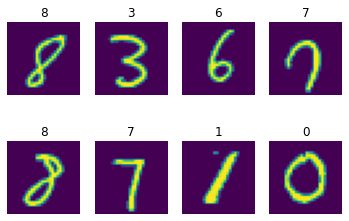

In [ ]:
fig, axs = plt.subplots(2, 4)
index = np.random.randint(len(trainX), size=8)
i = 0

for r in range(2):
    for c in range(4):
        axs[r, c].imshow(trainX[index[i]].reshape(28, 28))
        axs[r, c].set_title(str(trainY[index[i]]))
        axs[r, c].axis('off')
        i+=1

#### (b)

In [3]:
class linear_t:
    def __init__(self):
        # initialize to appropriate sizes, fill with Gaussian entires

        self.w = np.zeros([10, 784], dtype=np.float32)
        self.b = np.zeros([10, 1], dtype=np.float32)
        self.b = self.b + 0.0001

        self.hl = None
        self.dw = 0.0
        self.db = 0.0

    def forward(self, h_l):
        h_l1 = np.matmul(h_l, np.transpose(self.w)) + self.b.T
        # cache hˆl in forward because we will need it to compute
        # dw in backward
        self.hl = h_l
        return h_l1

    def backward(self, dh_l1):
        dh_l = np.matmul(dh_l1, self.w)
        dw = np.matmul(dh_l1.T, self.hl)
        db = np.matmul(dh_l1.T, np.ones([self.hl.shape[0], 1]))

        self.dw, self.db = dw, db

        return dh_l

    def zero_grad(self):
        # useful to delete the stored backprop gradients of the
        # previous mini-batch before you start a new mini-batch
        self.dw, self.db = 0.0 * self.dw, 0.0 * self.db

    def backward_check(self, dh_l1=np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]])):
        # PS: since the matrix dw is really sparse, it's good to try and visualize it
        # for picking i,j values or try many different values
        i, j = 7, 432

        k = np.argwhere(dh_l1 == 1)[0, 1]
        epsilon_ij = np.random.normal(0, 1)
        epsilon = np.zeros_like(self.w)
        epsilon[i, j] = epsilon_ij

        dw_ij_num = np.matmul((self.w + epsilon), self.hl.T)[k, 0] - np.matmul((self.w - epsilon), self.hl.T)[k, 0]
        dw_ij_den = 2 * epsilon_ij

        dw_ij = dw_ij_num / dw_ij_den

        return dw_ij, self.dw[i, j]

#### (c)

In [4]:
class relu_t:
    def __init__(self):
        self.relu = 0.0

    def forward(self, hl):
        self.relu = np.maximum(0.0, hl)
        return self.relu

    def backward(self, dhl):
        return dhl * (self.relu > 0)

    def zero_grad(self):
        self.relu = self.relu * 0.0

#### (d)

In [5]:
class softmax_cross_entropy_t:
    def __init__(self):
        self.targets = 0.0
        self.prob = 0.0

    def forward(self, hl, y):
        self.targets = y
        exp = np.exp(hl)
        prob = exp / np.sum(np.exp(hl), axis=1, keepdims=True)
        self.prob = prob
        log_prob = -np.log(prob[range(hl.shape[0]), y.astype(int)])
        # compute average loss ell(y) over a mini-batch
        ell = np.sum(log_prob) / hl.shape[0]
        error = np.sum(y != np.argmax(prob, axis=1)) / hl.shape[0]
        return ell, error

    def backward(self):
        dhl = self.prob
        dhl[range(self.prob.shape[0]), self.targets.astype(int)] -= 1
        dhl /= self.prob.shape[0]
        return dhl

    def zero_grad(self):
        self.prob = self.prob * 0.0
        self.targets = self.targets * 0.0

#### (f) & (g)

In [6]:
lr = 0.1
    
# initialize all the layers
l1, l2, l3 = linear_t(), relu_t(), softmax_cross_entropy_t()
net = [l1, l2, l3]

train_error_list = []
train_loss_list = []
val_error_list = []
val_loss_list = []

# train for at least 1000 iterations
for t in range(20000):
    # 1. sample a mini-batch of size bb = 32
    x, y = train_dataloader.__next__()
    x_val, y_val = val_dataloarder.__next__()

    # 2. zero gradient buffer
    for l in net:
        l.zero_grad()

    # 3. forward pass
    h1 = l1.forward(x)
    h2 = l2.forward(h1)
    ell, error = l3.forward(h2, y)

    # 4. backward pass
    dh2 = l3.backward()
    dh1 = l2.backward(dh2)
    dx = l1.backward(dh1)

    # 5. gather backprop gradients
    dw, db = l1.dw, l1.db

    # 6. print some quantities for logging
    # and debugging
    print(t, ell, error)

    train_loss_list.append(ell)
    train_error_list.append(error)

    # 7. one step of SGD
    l1.w = l1.w - lr * dw
    l1.b = l1.b - lr * db

    h1 = l1.forward(x_val)
    h2 = l2.forward(h1)
    val_loss, val_error = l3.forward(h2, y_val) 

    val_loss_list.append(val_loss)
    val_error_list.append(val_error)

Streaming output truncated to the last 5000 lines.
15001 0.14254742976342188 0.046875
15002 0.14015403647328123 0.046875
15003 0.3947403126005473 0.125
15004 0.2667508851424668 0.0625
15005 0.25451277274744116 0.09375
15006 0.13670931393511365 0.03125
15007 0.19760822211883933 0.0625
15008 0.20419069332418344 0.078125
15009 0.276663547327744 0.09375
15010 0.3145190061999448 0.125
15011 0.3558410132674272 0.09375
15012 0.36219276969052705 0.0625
15013 0.2805944736871662 0.078125
15014 0.18248474201199072 0.0625
15015 0.39164720000171666 0.125
15016 0.24107577023158447 0.078125
15017 0.32055339630340274 0.125
15018 0.21095199264853617 0.046875
15019 0.4551810959235355 0.109375
15020 0.20509029021470454 0.046875
15021 0.4658080275855501 0.078125
15022 0.28594977834210034 0.0625
15023 0.10657164358860284 0.015625
15024 0.219772342688785 0.03125
15025 0.19546447558457997 0.078125
15026 0.23042989765881006 0.09375
15027 0.304544076338999 0.109375
15028 0.12857146973616018 0.015625
15029 0.17

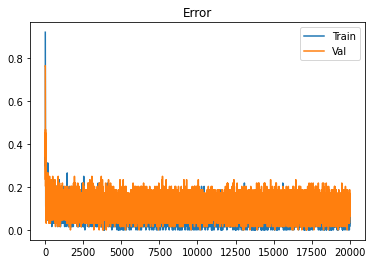

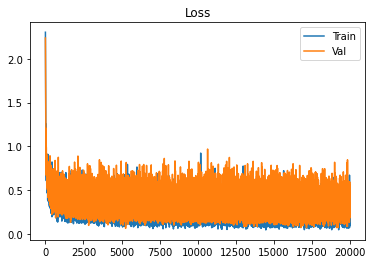

In [7]:
plt.plot(train_error_list, label='Train')
plt.plot(val_error_list, label='Val')
plt.legend()
plt.title('Error')
plt.show()

plt.plot(train_loss_list, label='Train')
plt.plot(val_loss_list, label='Val')
plt.legend()
plt.title('Loss')
plt.show()

#### (h)

In [8]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 10)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        return out


lr = 0.1
np.random.seed(20)

net = Net()
optimizer = optim.SGD(net.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

# load dataset
train = thv.datasets.MNIST('./', download=True, train=True)
val = thv.datasets.MNIST('./', download=True, train=False)

trainX, trainY = subsample(dataset=train, num_samples=30000, num_classes=10)
train_dataloader = batch_generator(trainX, trainY, batch_size=128)
valX, valY = subsample(dataset=val, num_samples=5000, num_classes=10)
val_dataloarder = batch_generator(valX, valY, batch_size=128)

train_error_list = []
train_loss_list = []
val_error_list = []
val_loss_list = []

# train for at least 1000 iterations
for t in range(10000):
    # 1. sample a mini-batch of size bb = 32
    x, y = train_dataloader.__next__()
    x_val, y_val = val_dataloarder.__next__()

    x = torch.Tensor(x)
    y = torch.Tensor(y).long()
    x_val = torch.Tensor(x_val)
    y_val = torch.Tensor(y_val).long()

    optimizer.zero_grad()

    outputs = net(x)
    loss = criterion(outputs, y)
    _, predicted = torch.max(outputs, 1)
    err = np.sum(np.array(y) != (predicted.numpy()))/x.shape[0]

    loss.backward()
    optimizer.step()

    print(t, loss.item(), err)
    train_loss_list.append(loss.item())
    train_error_list.append(err)

    with torch.no_grad():
        val_out = net(x_val)
        val_loss = criterion(val_out, y_val)
        _, val_pred = torch.max(val_out, 1)
        val_err = np.sum(np.array(y_val) != (val_pred.numpy()))/x_val.shape[0]
        val_loss_list.append(val_loss.item())
        val_error_list.append(val_err)
    


Streaming output truncated to the last 5000 lines.
5001 0.2657206356525421 0.046875
5002 0.3278246819972992 0.1015625
5003 0.2843320965766907 0.09375
5004 0.18621568381786346 0.046875
5005 0.15428759157657623 0.03125
5006 0.35600265860557556 0.0703125
5007 0.21467472612857819 0.0625
5008 0.44564875960350037 0.109375
5009 0.2684680223464966 0.078125
5010 0.41289034485816956 0.109375
5011 0.40486106276512146 0.140625
5012 0.2981073260307312 0.0703125
5013 0.35701102018356323 0.09375
5014 0.2352142333984375 0.0703125
5015 0.3830469250679016 0.109375
5016 0.3446047306060791 0.109375
5017 0.27306267619132996 0.078125
5018 0.3086124658584595 0.0859375
5019 0.17579251527786255 0.0390625
5020 0.2855754494667053 0.09375
5021 0.1749158650636673 0.0390625
5022 0.2652246654033661 0.0546875
5023 0.21433213353157043 0.046875
5024 0.3730292320251465 0.109375
5025 0.28297126293182373 0.1015625
5026 0.3417413532733917 0.09375
5027 0.24156571924686432 0.0859375
5028 0.28859198093414307 0.109375
5029 0.2

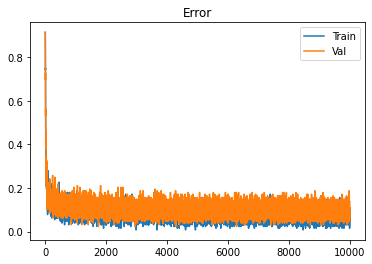

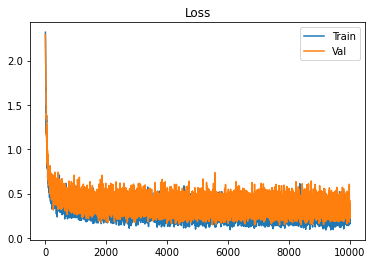

In [9]:
plt.plot(train_error_list, label='Train')
plt.plot(val_error_list, label='Val')
plt.legend()
plt.title('Error')
plt.show()

plt.plot(train_loss_list, label='Train')
plt.plot(val_loss_list, label='Val')
plt.legend()
plt.title('Loss')
plt.show()